In [14]:
# Imports: General tools
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('..')
from matplotlib import cm
import matplotlib.colors
from functools import partial

import pyDOE

# Imports: scikit-learn
from sklearn.gaussian_process.kernels import Matern
from sklearn.cluster import KMeans

# Imports: robustGP
from robustGP.SURmodel import AdaptiveStrategy
from robustGP.test_functions import branin_2d
import robustGP.tools as tools
import robustGP.gptools
import robustGP.enrichment.Enrichment as enrich
import robustGP.sampling.samplers as samplers
# Plotting options
plt.style.use("seaborn-v0_8")
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amssymb}",
    "font.family": "sans-serif",
    "font.serif": ["Computer Modern Roman"],
    'image.cmap': u'viridis',
    'figure.figsize': [8, 8],
    'savefig.dpi': 200
})

In [15]:
def initialize_branin(initial_design=None):
    """
    Create new instance of AdaptiveStrategy of the Branin 2d function
    with LHS as initial design
    """
    NDIM = 2
    if initial_design is None:
        initial_design = 5 * NDIM
    bounds = np.asarray([(0, 1)] * NDIM)
    initial_design = pyDOE.lhs(
        n=NDIM, samples=initial_design, criterion="maximin", iterations=50
    )
    branin = AdaptiveStrategy(bounds, branin_2d)
    branin.fit_gp(
        initial_design,
        branin.evaluate_function(initial_design),
        Matern(np.ones(NDIM)),
        n_restarts_optimizer=50,
    )
    branin.set_idxU([1], ndim=2)
    return branin

bounds = np.asarray([[0, 1], [0, 1]])
# For plots
npts = 2**5
x, y = np.linspace(0, 1, npts), np.linspace(0, 1, npts)
(XY, (xmg, ymg)) = tools.pairify((x, y))
xl, yl = np.linspace(0, 1, 500), np.linspace(0, 1, 500)
(XYl, (xmgl, ymgl)) = tools.pairify((xl, yl))

def plot_enrichment(adaptive, title=None):
    m, s = adaptive.predict(XY, return_std=True)
    plt.subplot(2, 2, 1)
    plt.contourf(x, y, adaptive.evaluate_function(XY).reshape(npts, npts).T)
    plt.colorbar()
    plt.scatter(adaptive.gp.X_train_[:10, 0], adaptive.gp.X_train_[:10, 1], marker='x', c='white', alpha=0.5)
    plt.scatter(adaptive.gp.X_train_[10:, 0], adaptive.gp.X_train_[10:, 1], marker='x', c='red', alpha=0.5)

    plt.title(r"$J$")

    plt.subplot(2, 2, 2)
    plt.contourf(x, y, m.reshape(npts, npts).T)
    plt.colorbar()
    plt.scatter(adaptive.gp.X_train_[:10, 0], adaptive.gp.X_train_[:10, 1], marker='x', c='white', alpha=0.5)
    plt.scatter(adaptive.gp.X_train_[10:, 0], adaptive.gp.X_train_[10:, 1], marker='x', c='red', alpha=0.5)
    plt.title(r"$m_Z$")

    plt.subplot(2, 2, 3)
    plt.contourf(x, y, s.reshape(npts, npts).T)
    plt.colorbar()
    plt.scatter(adaptive.gp.X_train_[:10, 0], adaptive.gp.X_train_[:10, 1], marker='x', c='white', alpha=0.5)
    plt.scatter(adaptive.gp.X_train_[10:, 0], adaptive.gp.X_train_[10:, 1], marker='x', c='red', alpha=0.5)
    plt.title(r"$\sigma^2_Z$")

    plt.subplot(2, 2, 4)
    plt.contourf(x, y, (m.reshape(npts, npts) - adaptive.function(XY).reshape(npts, npts))**2)
    plt.colorbar()
    plt.scatter(adaptive.gp.X_train_[:10, 0], adaptive.gp.X_train_[:10, 1], marker='x', c='white', alpha=0.5)
    plt.scatter(adaptive.gp.X_train_[10:, 0], adaptive.gp.X_train_[10:, 1], marker='x', c='red', alpha=0.5)
    plt.title(r"$|J - m_Z|^2$")

    plt.suptitle(title)
    plt.tight_layout()

In [22]:
def prob_coverage(m, s, T):
        return scipy.stats.norm.cdf((T - m) / s)

def indicator_coverage_alpha(sur_strat, candidate, alpha, eta=0.05):
    m, v = sur_strat.predict_GPdelta(candidate, alpha=alpha)
    pi = prob_coverage(m, np.sqrt(v), 0)
    return np.logical_and((pi <= 1-(eta/2)), (pi >= (eta/2)))


samplers.sampling_from_indicator(indicator_coverage_alpha, **{'alpha': 1.3, 'eta': 0.05})

def cluster_and_closest(samples, ncluster=8):
    kmeans = KMeans(n_clusters=ncluster).fit(samples)
    closest_samples = np.empty((ncluster, 2))
    for i, cen in enumerate(kmeans.cluster_centers_):
        closest_samples[i] = samples[np.sum((samples - cen) ** 2, 1).argmin()]
    return kmeans.labels_, kmeans.cluster_centers_, closest_samples


def adjustment(arg, closest_samples):
    X1, X2 = arg.separate_input(closest_samples)
    to_add = np.empty((len(X1), 2))
    for i, (x1, x2) in enumerate(zip(X1, X2)):
        set_input = arg.create_input(x2)
        x1_star = arg.get_conditional_minimiser(x2).x
        _, _, cov = robustGP.gptools.gp_to_delta(
            arg,
            set_input(x1).flatten(),
            set_input(x1_star).flatten(),
            alpha=1.3,
            beta=0,
            return_var=True,
        )
        if cov[0] > cov[1]:
            to_add[i] = closest_samples[i]
        else:
            to_add[i] = np.array([x1_star, x2]).squeeze()
    return to_add


In [23]:
def left_plot(branin, mean, std, Delta_true, new=0):
    plt.contourf(xmg, ymg, mean.reshape(npts, npts))
    if new == 0:
        plt.scatter(
            branin.gp.X_train_[:, 0],
            branin.gp.X_train_[:, 1],
            c="white",
            s=3,
            marker="x",
        )
    else:
        plt.scatter(
            branin.gp.X_train_[:, 0],
            branin.gp.X_train_[:, 1],
            c="white",
            s=3,
            marker="x",
        )
        # plt.plot(branin.gp.X_train_[new:, 0], branin.gp.X_train_[new:, 1], 'y')
    plt.contour(xmgl, ymgl, Delta_true, levels=[0], colors="yellow")
    plt.contour(
        xmg,
        ymg,
        prob_coverage(mean, std, 0).reshape(npts, npts),
        levels=[0.5],
        colors="lime",
        alpha=0.9,
    )
    plt.plot(np.nan, np.nan, color="yellow", label=r"$J = \alpha J^*$")
    plt.plot(np.nan, np.nan, color="lime", label=r"$m_{\Delta_{\alpha}} = 0$")
    leg = plt.legend(loc="upper right")
    for text in leg.get_texts():
        plt.setp(text, color="w")

    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$u$")
    plt.title(r"GP prediction")


def right_plot_bck(pi, title="", eta=0.05):
    cmap = matplotlib.colors.ListedColormap([cm.Pastel1(0), cm.Pastel1(1)])
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$u$")
    margin = np.logical_and(pi > eta/2, pi < 1 - (eta/2))
    plt.contourf(xmg, ymg, margin.reshape(npts, npts), cmap=cmap)
    plt.title(title)

In [24]:
branin = initialize_branin(10)
Jtrue = branin.function(XYl).reshape(500, 500)
Jstar = Jtrue.min(0)
alpha = 1.3
Delta_true = Jtrue - alpha * Jstar
mean, std2 = branin.predict_GPdelta(XY, alpha=alpha)
std = np.sqrt(std2)
pi = prob_coverage(mean, std, 0)
# -------


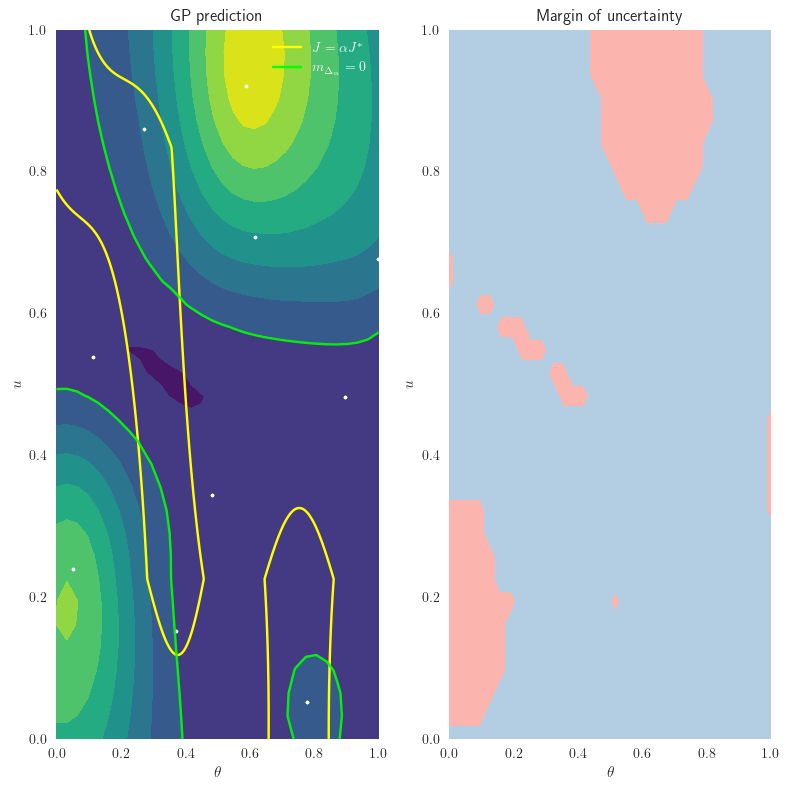

In [25]:
plt.subplot(1, 2, 1)
left_plot(branin, mean, std, Delta_true=Delta_true)
plt.subplot(1, 2, 2)
right_plot_bck(pi, "Margin of uncertainty")
plt.tight_layout()

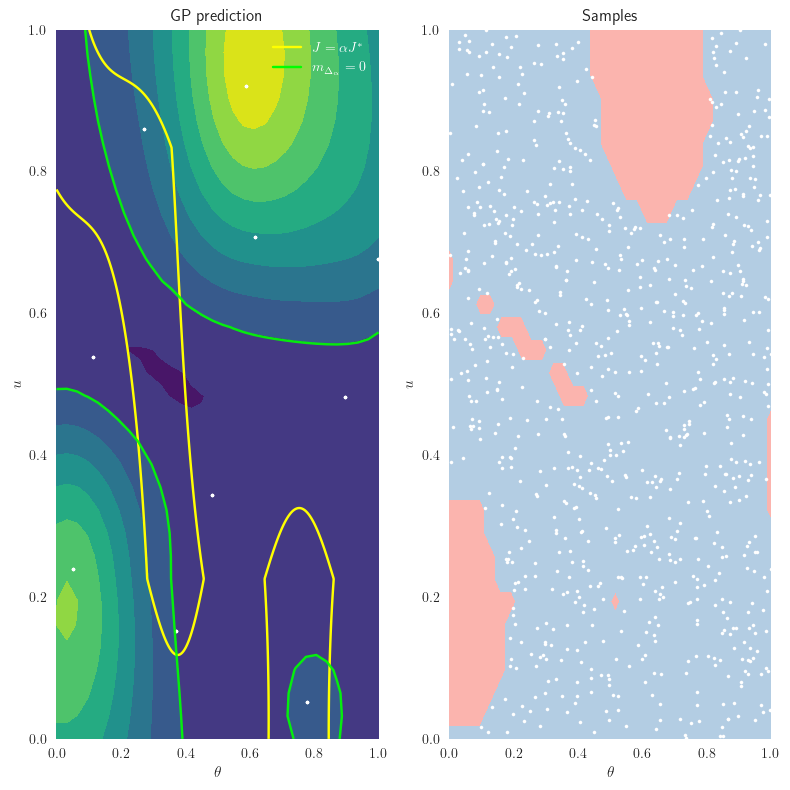

In [26]:
plt.subplot(1, 2, 1)
left_plot(branin, mean, std, Delta_true=Delta_true)
plt.subplot(1, 2, 2)
right_plot_bck(pi, "Samples")
samples = sample_in_margin(800, branin, 0)
plt.scatter(samples[:, 0], samples[:, 1], c="white", s=5)
plt.tight_layout()

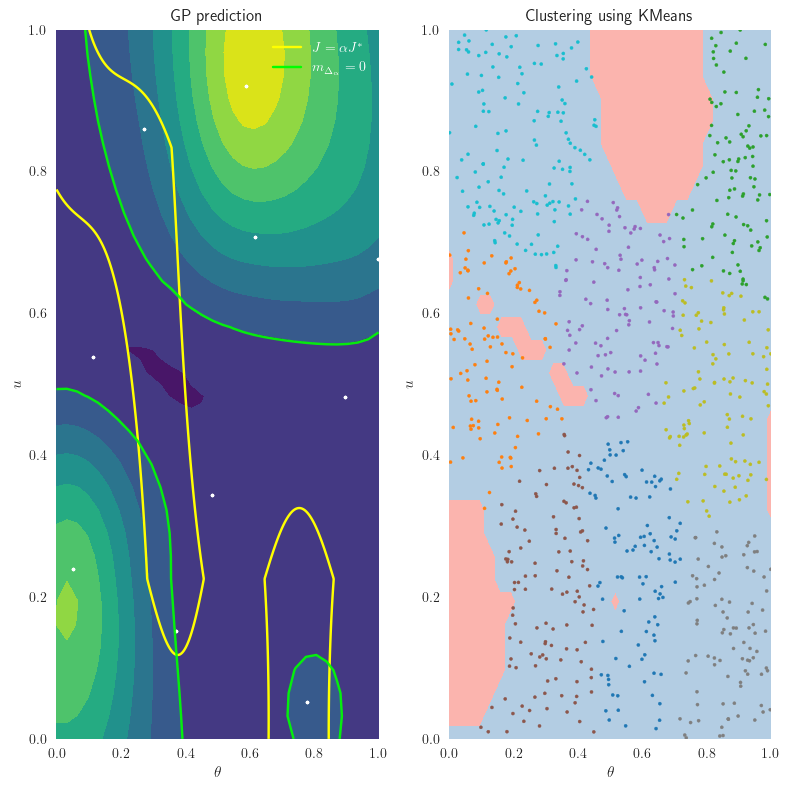

In [27]:
plt.subplot(1, 2, 1)
left_plot(branin, mean, std, Delta_true=Delta_true)
plt.subplot(1, 2, 2)
right_plot_bck(pi, "Clustering using KMeans")
labels, center, closest = cluster_and_closest(samples, 8)
plt.scatter(samples[:, 0], samples[:, 1], c=labels, cmap=cm.tab10, s=5)
to_add = adjustment(branin, closest)
# plt.plot(to_add[:, 0], to_add[:, 1], '*', c='yellow')
plt.tight_layout()

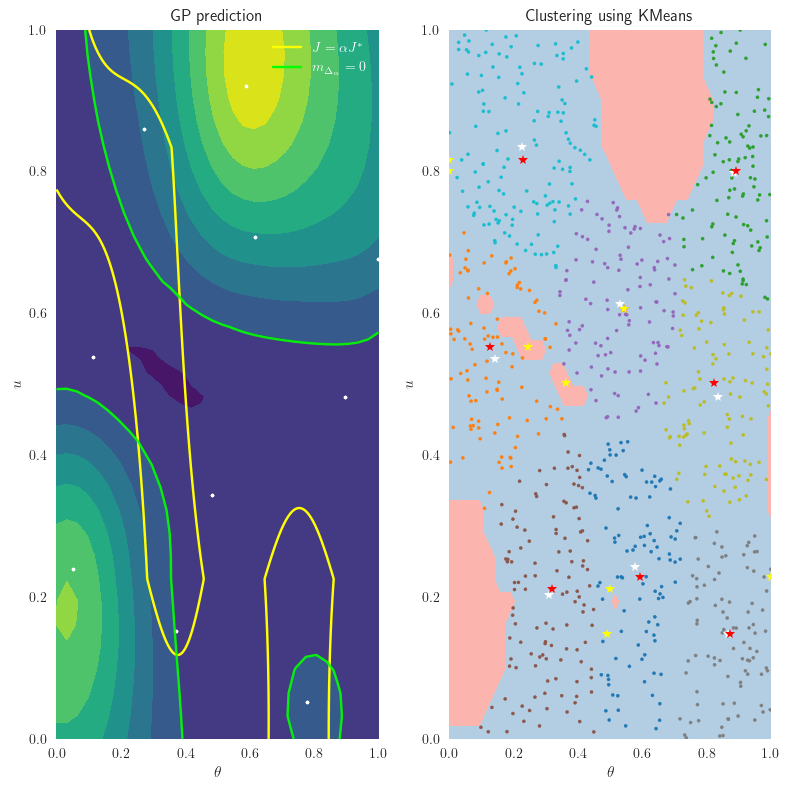

In [28]:
plt.subplot(1, 2, 1)
left_plot(branin, mean, std, Delta_true=Delta_true)
plt.subplot(1, 2, 2)
right_plot_bck(pi, "Clustering using KMeans")
plt.scatter(samples[:, 0], samples[:, 1], c=labels, cmap=cm.tab10, s=5)
plt.plot(center[:, 0], center[:, 1], "*", c="white")
plt.plot(closest[:, 0], closest[:, 1], "*", c="red")
to_add = adjustment(branin, closest)
plt.plot(to_add[:, 0], to_add[:, 1], "*", c="yellow")

plt.tight_layout()

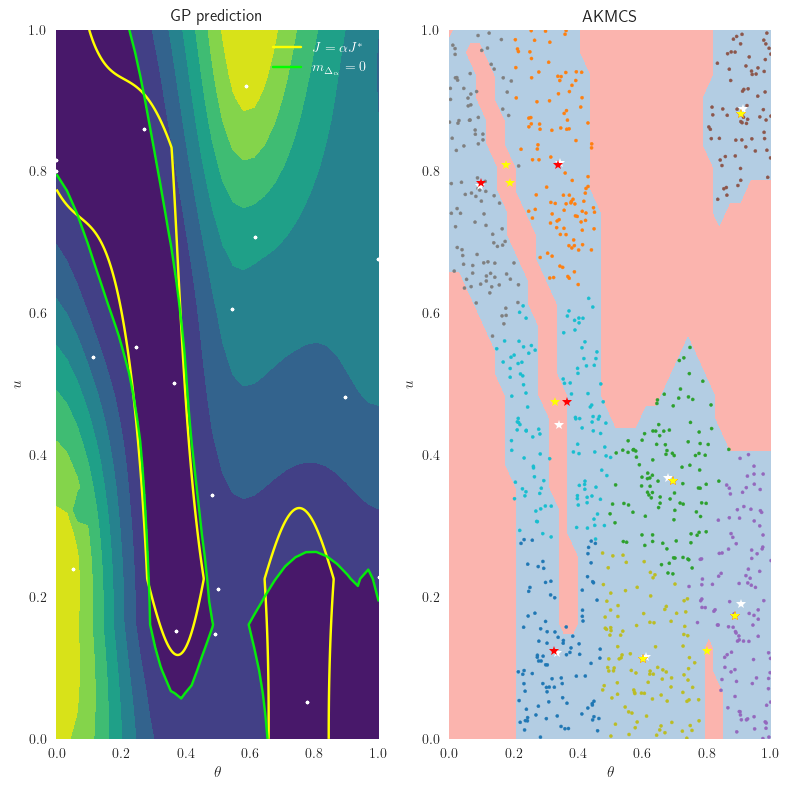

In [29]:
branin.add_points(to_add)
mean, std2 = branin.predict_GPdelta(XY, alpha=alpha)
std = np.sqrt(std2)
pi = prob_coverage(mean, std, 0)

plt.subplot(1, 2, 1)
left_plot(branin, mean, std, Delta_true=Delta_true, new=8)
plt.subplot(1, 2, 2)
right_plot_bck(pi, "AKMCS")
samples = sample_in_margin(800, branin, 0)
labels, center, closest = cluster_and_closest(samples, 8)
plt.scatter(samples[:, 0], samples[:, 1], c=labels, cmap=cm.tab10, s=5)
plt.plot(center[:, 0], center[:, 1], "*", c="white")
plt.plot(closest[:, 0], closest[:, 1], "*", c="red")
to_add = adjustment(branin, closest)
plt.plot(to_add[:, 0], to_add[:, 1], "*", c="yellow")
plt.tight_layout()

In [30]:
akmcs = enrich.AKMCSEnrichment(bounds)